In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import re
import csv
from scipy import stats, integrate
from scipy.stats import spearmanr
%matplotlib inline

Use this dataset of airline arrival information to predict how late flights will be. A flight only counts as late if it is more than 30 minutes late.

In [2]:
airline = pd.read_csv("2004.csv.bz2")

In [25]:
#I begin exploring my data by seeing how long the dataset is. 
print(len(airline))

7129270


Because this dataset is so large, I am taking a random sample to use with my models. 

In [3]:
test = airline.sample(frac=0.05)

In [27]:
#Before I go any further I want to check in there are any null values in my dataset
print(test.isnull().sum())

Year                      0
Month                     0
DayofMonth                0
DayOfWeek                 0
DepTime                6382
CRSDepTime                0
ArrTime                7102
CRSArrTime                0
UniqueCarrier             0
FlightNum                 0
TailNum                   2
ActualElapsedTime      7102
CRSElapsedTime            0
AirTime                7102
ArrDelay               7102
DepDelay               6382
Origin                    0
Dest                      0
Distance                  0
TaxiIn                    0
TaxiOut                   0
Cancelled                 0
CancellationCode     350082
Diverted                  0
CarrierDelay              0
WeatherDelay              0
NASDelay                  0
SecurityDelay             0
LateAircraftDelay         0
dtype: int64


From the null values listed above, I can see that there are 7102 missing values for Arrival Delay. These could be due to the flight being cancelled or diverted. But regardless, these data points will not be able to accurately inform my model about how late flights will be.

In [4]:
# Dropping the rows with null values in the Arrival Delay column
test = test.dropna(axis=0, subset=['ArrDelay'])

Next, I want to view the correlation of the continuous features to the outcome feature.

In [30]:
# I've isolated my features from the dataset
feature = test.loc[:,['ArrDelay', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 
                               'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 
                               'AirTime', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
                               'CancellationCode', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
                               'LateAircraftDelay']]

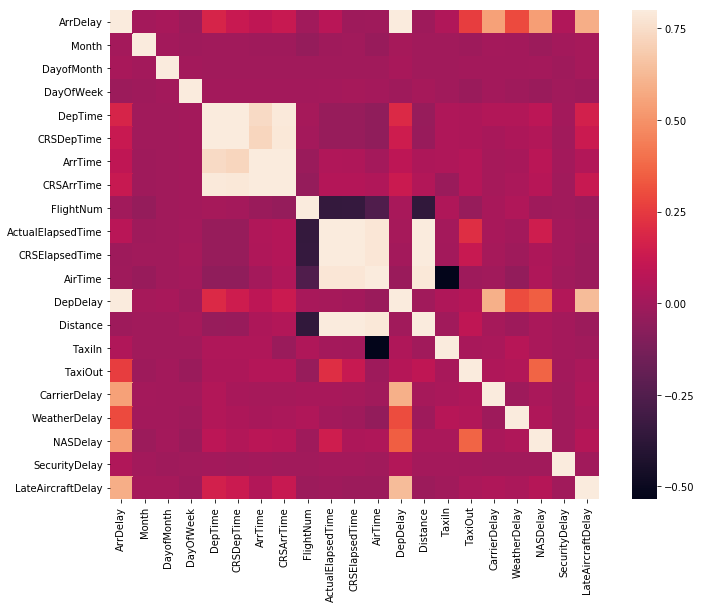

In [31]:
corrmat = feature.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

In [32]:
# The exact correlation numbers for all the features. 
corrmat

,ArrDelay,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,...,AirTime,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
ArrDelay,1.000000,0.007507,0.021939,-0.017877,0.177781,0.124055,0.094248,0.120117,0.000491,0.074797,...,-0.007029,0.913038,-0.012719,0.046089,0.258710,0.547976,0.295337,0.537033,0.048688,0.589379
Month,0.007507,1.000000,0.004035,-0.004973,-0.000302,-0.000619,-0.003409,-0.003332,-0.036695,-0.006777,...,-0.027233,0.017154,-0.002209,0.001424,-0.013186,0.007412,0.003100,-0.015092,0.006362,0.015087
DayofMonth,0.021939,0.004035,1.000000,0.002628,-0.001044,-0.002543,-0.001158,-0.000413,-0.001809,0.002019,...,0.000756,0.018418,0.000170,0.000671,0.003102,0.006961,0.006930,0.009058,-0.003569,0.014721
DayOfWeek,-0.017877,-0.004973,0.002628,1.000000,0.005015,0.005885,0.006482,0.005793,0.004656,0.007638,...,0.010427,-0.005416,0.014373,-0.000764,-0.018937,0.003796,-0.006705,-0.019740,0.000745,-0.008629
DepTime,0.177781,-0.000302,-0.001044,0.005015,1.000000,0.974544,0.740924,0.791187,0.014340,-0.030785,...,-0.054880,0.195770,-0.031716,0.043269,0.038621,0.053330,0.051177,0.080489,0.002927,0.159166
CRSDepTime,0.124055,-0.000619,-0.002543,0.005885,0.974544,1.000000,0.725831,0.787586,0.009324,-0.030504,...,-0.051581,0.138962,-0.028321,0.039775,0.037062,0.019428,0.036553,0.050212,-0.002823,0.130585
ArrTime,0.094248,-0.003409,-0.001158,0.006482,0.740924,0.725831,1.000000,0.895706,-0.023485,0.048687,...,0.007679,0.089545,0.034983,0.041379,0.058240,0.014207,0.021500,0.080196,0.002894,0.051831
CRSArrTime,0.120117,-0.003332,-0.000413,0.005793,0.791187,0.787586,0.895706,1.000000,-0.035101,0.057446,...,0.048421,0.129664,0.049500,-0.020581,0.054805,0.016347,0.029906,0.065714,0.000084,0.119874
FlightNum,0.000491,-0.036695,-0.001809,0.004656,0.014340,0.009324,-0.023485,-0.035101,1.000000,-0.348192,...,-0.254920,0.018287,-0.360688,0.041680,-0.033901,0.018151,0.047489,-0.007614,-0.000848,-0.016612
ActualElapsedTime,0.074797,-0.006777,0.002019,0.007638,-0.030785,-0.030504,0.048687,0.057446,-0.348192,1.000000,...,0.781118,0.013092,0.968985,0.007977,0.215765,0.020640,0.002824,0.145443,0.008211,-0.007608


In [33]:
# Sorting features that correlate to Arrival Delay by descending order. 
corrmat['ArrDelay'].sort_values(ascending=False)

ArrDelay             1.000000
DepDelay             0.913038
LateAircraftDelay    0.589379
CarrierDelay         0.547976
NASDelay             0.537033
WeatherDelay         0.295337
TaxiOut              0.258710
DepTime              0.177781
CRSDepTime           0.124055
CRSArrTime           0.120117
ArrTime              0.094248
ActualElapsedTime    0.074797
SecurityDelay        0.048688
TaxiIn               0.046089
DayofMonth           0.021939
Month                0.007507
FlightNum            0.000491
AirTime             -0.007029
Distance            -0.012719
CRSElapsedTime      -0.012826
DayOfWeek           -0.017877
Name: ArrDelay, dtype: float64

In [5]:
# These are the features that have the highest correlation to Arrival Delay. 
X = test[['DepDelay', 'LateAircraftDelay', 'CarrierDelay', 'NASDelay', 'WeatherDelay', 'TaxiOut']]
Y = test.ArrDelay

## KNN Regression Model

In [35]:
from sklearn import neighbors
neighbors = neighbors.KNeighborsRegressor(n_neighbors=5)
neighbors.fit(X,Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [36]:
from sklearn.model_selection import cross_val_score
knn_score = cross_val_score(neighbors, X, Y, cv=5)
print('\nEach Cross Validated R2 score: \n', knn_score)
print("\nOverall KNN Regression R2: %0.2f (+/- %0.2f)\n" % (knn_score.mean(), knn_score.std() * 2))


Each Cross Validated R2 score: 
 [ 0.94153342  0.93525994  0.93100301  0.94014526  0.94159478]

Overall KNN Regression R2: 0.94 (+/- 0.01)



## Random Forest Regression Model

In [37]:
from sklearn import ensemble
rfr = ensemble.RandomForestRegressor()
rfr.fit(X,Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [38]:
rfr_score = cross_val_score(rfr, X, Y, cv=5)
print('\nEach Cross Validated R2 score: \n', rfr_score)
print("\nOverall Random Forest Regression R2: %0.2f (+/- %0.2f)\n" % (rfr_score.mean(), rfr_score.std() * 2))


Each Cross Validated R2 score: 
 [ 0.95218724  0.94438426  0.94668547  0.94900289  0.94984141]

Overall Random Forest Regression R2: 0.95 (+/- 0.01)



## Support Vector Classifier Model

In [6]:
# Recode ArrDelay column to binary.
test['ArrDelay'] = np.where(test['ArrDelay']>=30, 1, 0)

In [7]:
X = test[['DepDelay', 'LateAircraftDelay', 'CarrierDelay', 'NASDelay', 'WeatherDelay', 'TaxiOut']]
Y = test.ArrDelay

In [8]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear')
svm.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [10]:
svm_score = cross_val_score(svm, X, Y, cv=5)
print('\nEach Cross Validated R2 score: \n', svm_score)
print("\nOverall SVM Classification R2: %0.2f (+/- %0.2f)\n" % (svm_score.mean(), svm_score.std() * 2))


Each Cross Validated R2 score: 
 [ 0.99928453  0.99957072  0.99917004  0.99921297  0.99947054]

Overall SVM Classification R2: 1.00 (+/- 0.00)

